# Mathematical Modeling and Numerical Simulation of Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket 

# Introduction

This project, conducted through **TU Delft**, focuses on **hydrogen storage optimization**, a key aspect of the **energy transition**. I'll be working with **Almajdouie MdR**, a company specializing in **hydrogen transport and logistics solutions** in the Gulf region.

The aim of this project is to contribute to the deployment of hydrogen gas as a sustainable fuel in the Persian Gulf. In particular, it involves designing infrastructures for storing, transporting and distributing hydrogen. Other objectives include the study of alternative modes of transport and energy production to accelerate the adoption of hydrogen as an energy fuel. Mathematical modeling techniques and numerical simulation tools should provide essential information for comparing different scenarios.

In the Persian Gulf, the combined use of solar and wind energy should play a crucial role in the production of sustainable (green) hydrogen gas produced by the electrolysis. Hydrogen has the potential to replace hydrocarbon-based fuels, enabling clean combustion without the formation of pollutants. This combustion can provide energy in a number of ways. It can produce heat (domestic boilers), power electricity generation (see, for example, recent studies on (micro) gas turbines) and be used as fuel in internal combustion engines or fuel cells for cars and trucks. However, hydrogen has a small molecular size and low density. Hydrogen storage (e.g. at low temperature and high pressure) is therefore a well-known technical challenge.

---

The **main goal** of this notebook is to reproduce the results by Darzi e.a. in their 2016 paper entitled <i>Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket</i>. This paper discusses the mathematical modeling and numerical simulation of metal-hydride materials for the storage (absorption (intake) and desorption (release)) of hygrogen gas. The [Van 't Hoff plot](https://en.wikipedia.org/wiki/Van_'t_Hoff_equation) is used to estimate the enthalpy (heat intake or release) and entropy of the chemical reaction of binding and release of hydrogen gas; 

<img src="./darzi-2016-table1.png" width=800 />

**Table 1 from Darzi-2016.** 

The work is structured into **three main phases**, each addressing a critical aspect of **hydrogen storage modeling**.

**1. Research on Composite Materials & Laminar Flow Modeling**
- Investigating **composite materials** used for hydrogen storage, particularly Metal-Organic Frameworks (MOFs) and metal oxides.
- Assessing **safety, durability, and efficiency** of these materials in hydrogen absorption and desorption.
- Developing a **laminar flow model for hydrogen transport in porous materials**, using numerical methods:
  - Finite Difference Method (FDM)
  - Finite Volume Method (FVM)
  - Finite Element Method (FEM)
- **Tools & Programming**: *ANSYS, ABAQUS, Julia*.



**2. Convection-Diffusion-Reaction Model**
- Studying **hydrogen interactions with hydride materials** through a simplified flow model.
- Implementing **PDE-based numerical models** using Julia and Python.
- **Visualization** of simulation results with maybe PARAVIEW.



**3. Combined Multi-Physics Model**
- Developing a fully coupled model integrating:
  - **Fluid flow**
  - **Structural mechanics**
  - **Chemical reactions**
- Using **FEM-based tools** (*HyperMesh, OptiStruct, ABAQUS*) to optimize hydrogen storage tank design.
- Investigating **storage density improvements, tank filling/unloading conditions, and MOF adsorption parameters (pressure, temperature effects).**

---

**Personal Motivation**

This project aligns perfectly with my career goals in renewable energy and advanced structural modeling.  
Hydrogen technology is crucial to the energy transition, and I am eager to contribute to innovative solutions in this field.  
Additionally, this internship will allow me to apply my expertise in numerical simulation and engineering analysis in a real-world context.  


## Import Julia Packages 

In [1]:
using LinearAlgebra
using DifferentialEquations
using Plots
using Ferrite
using SparseArrays
using Parameters
using OrdinaryDiffEq

In [2]:
# deliberately use include to include code 
# see e.g. https://docs.julialang.org/en/v1/manual/code-loading/ 
include("flemish-fish.jl")

In [3]:
?fdmmesh

search: fdmmesh



Generates a one-dimensional uniform mesh between point 0 and 1

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int})`](@ref)

---

Generates a one-dimensional uniform mesh between point a and b

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int},::Real,::Real)`](@ref)

---

Generates a two-dimensional mesh between the points (0,0) and (1,1) 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int})`](@ref)

---

Generates a two-dimensional mesh between the points a and b 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int},::Point2D,::Point2D)`](@ref)


# Section 1: Research & Literature Review 

## 1.1 State-of-the-art review on Hydrogen Storage Technologies

Hydrogen has a high energy content per unit mass of 120.1 MJ/kg, but its low density at ambient temperature results in an extremely low energy density of 0.01 MJ/L. Consequently, a large volume of hydrogen is required to deliver the same energy output as conventional fuels. For instance, storing 1 kg of hydrogen—enough to travel approximately 100 km—would require 11.2 Nm³ of space (normal cubic meters, it refers to the volume occupied by 1 kg of hydrogen gas under standard temperature and pressure (STP) conditions, typically defined as 0°C and 1 atm), roughly the size of the trunk of a large utility or commercial vehicle. Therefore, to make hydrogen storage economically viable, its storage density must be improved.

Hydrogen storage can be categorized into physical and material-based storage methods (see Figure 1). In physical storage, hydrogen is kept in its pure molecular form as either a gas or liquid, without significant physical or chemical interactions with other materials. The following sections analyze these physical storage methods, which are currently used on a large scale.

<img src="./hydrogen_storage.png" width=400 />

**Figure 1 from [How Hydrogen Is Stored ?](https://www.energy.gov/eere/fuelcells/hydrogen-storage) - U.S. Department of Energy.**


###  1.1.1 Physical Hydrogen Storage

**Compressed Hydrogen Gas**

Compressed hydrogen storage involves storing hydrogen gas at high pressures (350-700 bar) in reinforced tanks for small-scale storage or geological formations for large-scale reserves.

There are four types of high-pressure tanks used for hydrogen storage:
- Type I: Metal pressure vessels (150-300 bar), widely used in industrial applications but too heavy for vehicles.
- Type II: Metal liner wrapped with carbon or glass fibre, capable of handling pressures up to 1000 bar, mainly used in high-pressure hydro generators.
- Type III: Composite-wrapped metal liner, reducing weight while preventing hydrogen leakage, making them suitable for mobility applications.
- Type IV: High-density polymer liner, which acts as a gas diffusion barrier, fully enclosed in carbon fibre composites, designed for portable applications at pressures up to 700 bar.

Underground hydrogen storage offers a large-scale and long-term solution, utilizing salt caverns, depleted natural gas fields, and oil reservoirs. The largest salt cavern storage facility in the U.S. holds 10,000-20,000 tonnes of hydrogen, equivalent to 30 days of production. Oil and gas fields provide greater storage capacity but are more permeable and require purification before hydrogen can be used in fuel cells. Water aquifers are a less mature option, with ongoing research assessing their feasibility.

*Sources:*
- [U.S. Department of Energy – Physical Hydrogen Storage](https://www.energy.gov/eere/fuelcells/physical-hydrogen-storage)
- [Hydrogen Storage Methods – SynerHy](https://synerhy.com/en/2022/02/hydrogen-storage-methods/)  

---

**Liquid Hydrogen (LH₂)**
Liquid hydrogen (LH₂) is produced by cooling hydrogen gas to cryogenic temperatures (-252.8°C), significantly increasing its energy density (8.4 MJ/L). The liquefaction process uses compressors, heat exchangers, and expansion valves, following cycles like the [Linde cycle](https://www.youtube.com/watch?v=68zcJBzut5s), where hydrogen is compressed, cooled, and expanded to achieve liquefaction. Storage vessels are double-walled and insulated to minimize boil-off losses, which in large spherical tanks remain below 0.1% per day. In this method, nitrogen is mix with hydrogen, reducing its purity and requiring additional separation processes before use in fuel cells or industrial applications.

LH₂ is widely used in Germany’s hydrogen refueling stations, where it is transported in liquid form before being converted back into gas and compressed up to 1000 bar for refueling. While liquid hydrogen offers the highest storage density, it requires high energy input for liquefaction and long loading/unloading times, making it less suitable for long-term storage. 

*Sources:* 
- [NASA – Liquid Hydrogen Storage](https://ntrs.nasa.gov/search?q=liquid%20hydrogen&page=%7B%22from%22:0,%22size%22:25%7D)  
- [Hydrogen Storage Methods – SynerHy](https://synerhy.com/en/2022/02/hydrogen-storage-methods/)
- [Hydrogen Stations](https://h2.live/en/)  

---

**3. Cryo-Compressed Hydrogen (CcH₂)**
Cryo-compressed hydrogen storage (CcH₂) is a hybrid method combining compressed hydrogen (CH₂) and liquid hydrogen (LH₂). It stores hydrogen at cryogenic temperatures within a pressurized vessel (250-350 bar), allowing it to remain in liquid, supercritical, or two-phase form (saturated liquid and vapor). By using insulated pressure vessels, CcH₂ addresses some of the limitations of CH₂ and LH₂, offering higher storage density and reduced boil-off losses. However, this technology is still under development and not yet widely deployed.

*Source:*  
- [Techno-Economic Analysis of Green Hydrogen Energy Storage in A Cryogenic Flux Capacitor](https://ntrs.nasa.gov/citations/20240011295)  
- [Hydrogen Storage Methods – SynerHy](https://synerhy.com/en/2022/02/hydrogen-storage-methods/)

Next, we explore material-based hydrogen storage, which relies on adsorption on solid surfaces (via van der Waals forces) or absorption of atomic hydrogen within solid materials. Storage by absorption can be accomplished by means of liquid organic hydrogen carriers, metal hydrides, complex hydrides or chemical hydrides.

### 1.1.2 Material-Based Storage

**Metal Hydrides**

Metal hydrides store hydrogen by absorbing hydrogen atoms into the interstitial sites of the solid metal lattice in materials such as magnesium, titanium, nickel, and iron-based alloys. During absorption, hydrogen molecules first dissociate into atoms on the metal surface before diffusing into the lattice, where they form metal-hydrogen bonds. This process is reversible and controlled by pressure and temperature: at high pressure, hydrogen is absorbed into the metal, forming the hydride, while at lower pressure, hydrogen is released.

Metal hydrides provide higher volumetric hydrogen density than compressed or liquid hydrogen storage, as hydrogen atoms are tightly packed within the metal structure. However, they also suffer from low gravimetric density due to the high weight of the metal itself, limiting their use in mobile applications, such as hydrogen-powered vehicles, where lightweight storage is essential for efficiency and performance.

Additionally, the strong chemical bonding between hydrogen and metal requires high energy input for hydrogen release, making desorption slower and more energy-intensive. Metal hydrides are also sensitive to oxygen and carbon monoxide, which can reduce hydrogen adsorption capacity and affect long-term stability.

Complex metal hydrides, such as alanates, borohydrides, and amides, offer higher gravimetric storage capacity by storing hydrogen in molecular anion complexes rather than in direct metal bonds. These materials have gained interest for fuel cell vehicle (FCV) applications, but most require high temperatures for hydrogen release and are not easily reversible without the use of catalysts or additives.

*Source:* [New Approaches to Hydrogen Storage](https://pubs.rsc.org/en/content/articlehtml/2009/cs/b718842k) - Tutorial Review by Jason Graetz, Chemical Society Reviews, 2008.

--- 

**Liquid Organic**

Liquid Organic Hydrogen Carriers (LOHCs) are organic compounds that store hydrogen reversibly through hydrogenation (absorption) and dehydrogenation (release) reactions. In this process, hydrogen is chemically bonded to a liquid carrier under moderate cooling and pressurization at the source. Once hydrogenated, the liquid can be safely transported using conventional fuel infrastructure such as pipelines, trucks, or ships. At the destination, the carrier is heated, triggering hydrogen release, and the liquid returns to its original form for reuse.

LOHCs enable hydrogen storage at ambient pressure and temperature, reducing the need for high-pressure tanks or cryogenic systems. Because this chemical reaction does not involve carbon-based or nitrogen-based compounds, there are no byproducts like carbon dioxide (production from fossil fuels) or nitrogen gas that need to be managed or separated.
They can integrate into existing industrial storage and transport infrastructure, making them a scalable solution for large-scale hydrogen logistics.
For effective operation, LOHCs should have high boiling points, allowing for easier hydrogen separation, and low freezing points, ensuring fluidity at low temperatures to prevent operational issues like pipeline clogging. However, challenges remain, including economic feasibility, safety considerations, and hydrogen storage capacity, which should ideally exceed 6% of the total carrier weight.

Not all liquid organic compounds qualify as LOHCs. For instance, methanol and formic acid, despite being liquid and organic, do not meet the definition because their dehydrogenation results in gaseous byproducts, making them less efficient for practical hydrogen storage applications.

*Source:* [Hydrogen Storage Methods](https://synerhy.com/en/2022/02/hydrogen-storage-methods/) – SynerHy


--- 

**Chemical Hydrogen Storage**

Chemical hydrides are non-metallic compounds that store hydrogen through covalent bonds, allowing for stable and high-density hydrogen storage. Unlike metal hydrides, chemical hydrides are generally lighter and exist in liquid form at ambient conditions, making transport and storage easier without the need for high-pressure tanks or cryogenic systems. Their liquid state enhances heat and mass transfer, facilitating the hydrogenation (absorption) and dehydrogenation (release) processes.

Hydrogen stored in chemical hydrides is released through chemical reactions, often by hydrolysis (reaction with water) or thermal decomposition. However, unlike LOHCs, many chemical hydrides are not reversible, meaning that after hydrogen is released, the compound is permanently altered and cannot be reused in its original form.

Several chemical hydrides, such as methanol (CH₃OH), ammonia (NH₃), and formic acid (HCOOH), are already widely produced in the chemical industry, primarily from natural gas. Their existing production, storage, and transportation infrastructure makes them attractive for large-scale hydrogen storage applications.

Additionally, if these chemicals were synthesized using hydrogen from water electrolysis instead of fossil fuel-based hydrogen, they could serve as both hydrogen carriers and a way to reduce fossil fuel consumption, contributing to a more sustainable hydrogen economy.

*Source:* [Hydrogen Storage Methods](https://synerhy.com/en/2022/02/hydrogen-storage-methods/) – SynerHy

--- 

**Adsorbent : The Example of Metal-Organic Frameworks (MOFs)**

Metal-Organic Frameworks (MOFs) are highly porous crystalline materials composed of metal ions coordinated to organic ligands, forming a structured network with an exceptionally high surface area and tunable pore sizes. These characteristics make MOFs excellent candidates for hydrogen storage, as they can adsorb hydrogen molecules through physisorption.

MOFs store hydrogen via physisorption, a reversible process where hydrogen molecules adhere to the porous surface through weak Van der Waals interactions. Unlike chemisorption, this process does not involve chemical bonding, so the hydrogen remains intact and can be easily released. Physisorption requires low adsorption energy (typically 5–20 kJ/mol), making it an energy-efficient storage method compared to metal hydrides or chemical hydrogen storage.

The hydrogen uptake capacity of MOFs is influenced by:
- Pore size: Determines how effectively hydrogen molecules are trapped within the structure.
- Surface area: Higher surface area increases storage capacity.
- Functionalization of the framework: Chemical modifications can enhance hydrogen affinity and improve adsorption efficiency.
Studies have shown that optimizing these parameters can significantly improve hydrogen adsorption, making MOFs a promising technology for efficient and scalable hydrogen storage solutions.  

*Source:* [Metal organic framework for hydrogen storage](https://www.researchgate.net/publication/362452086_Metal_organic_framework_for_hydrogen_storage) - Yiling Chen et al. Highlights in Science, Engineering and Technology, 2022.


### 1.1.3 Comparative table

After reviewing these storage methods, a comparative table has been created to evaluate their performance based on factors such as storage capacity, weight, charging and discharging times and temperatures, parasitic losses, safety concerns, risk of corrosion, risk of fire, and cost.

| Storage Method                          | Storage Capacity (wt%)  | Weight (H₂ per 100 kg)  | Charging & Discharging Times/Temperatures  | Parasitic Losses | Safety Concerns                                  | Risk of Corrosion                                | Risk of Fire                                      | Cost (/kg H₂ stored) | Usage Applications  |
|-----------------------------------------|-------------------------|-------------------------|------------------------------------------|------------------|--------------------------------------------------|------------------------------------------------|--------------------------------------------------|-----------------------|----------------------|
| **Metal Hydrides**                      | 1-2%                    | High (approx. 3-6 kg H₂ per 100 kg)       | Slow, requires **300-400°C** for release | Minimal (<5%)    | Sensitive to O₂ & CO contamination              | Possible due to metal oxidation                 | Low                                              | Moderate to high  $10 - 50$ | **Stationary storage, fuel cells** |
| **Liquid Organic Hydrogen Carriers (LOHCs)** | 6-7%                 | Low (approx. 6-7 kg H₂ per 100 kg)        | Moderate, requires **150-200°C**         | Possible losses (5-10%) | Requires handling of organic solvents          | Low                                            | Low to moderate (depends on carrier)             | High  $50 - 100$ | **Hydrogen transport, industrial storage** |
| **Chemical Hydrogen Storage**           | 10-18%                  | Low to Moderate (approx. 10-18 kg H₂ per 100 kg) | Fast for hydrolysis, slow for thermal (>200°C) | Varies, potential byproducts | Ammonia is toxic, methanol is flammable         | Depends (e.g., ammonia can be corrosive)        | Moderate to high (methanol, ammonia, formic acid are flammable) | Varies  $5 - 30$ | **Hydrogen fuel, industrial processes, ammonia synthesis** |
| **Metal-Organic Frameworks (MOFs)**     | 3-6%                    | Very low (approx. 3-6 kg H₂ per 100 kg)   | Fast at low T, but needs cryogenic conditions (-196°C) | Minimal, but cooling needed | Stable but can release gas if not stored properly | Low                                            | Low                                              |Very high $100 - 500$| **Experimental, future hydrogen transport & storage** |


*Sources:*

- [Hydrogen Storage Methods](https://synerhy.com/en/2022/02/hydrogen-storage-methods/) - SynerHy, 2022.  

- [Strategies for Hydrogen Storage in Metal-Organic Frameworks](https://onlinelibrary.wiley.com/doi/10.1002/anie.200462786) - J. L. C. Rowsell & O. M. Yaghi, *Angewandte Chemie International Edition*, 2005.  

- [Hydrogen Storage Technologies Overview](https://www.energy.gov/eere/fuelcells/hydrogen-storage) - *U.S. Department of Energy*.


### 1.1.4 Interesting developments

**Scania Production Zwolle** has introduced a new gas truck model with the largest gas tank ever installed in their production. Traditionally, Scania gas trucks have two tanks (left and right), but this new version features an enlarged right-side tank, increasing total gas storage capacity. 

This innovation responds to market demand by allowing trucks to cover longer distances with fewer refueling stops. Technical modifications included ordering over 600 new lifting tools, adjusting the pre-assembly tank support, and designing a new gas panel fixture. The project involved successful collaboration with Scania’s Swedish and Brazilian teams. 

While this development focuses on compressed or liquefied natural gas (CNG/LNG), it is not directly related to hydrogen. However, Scania is also working on hydrogen-powered trucks, and this type of innovation in tank design could potentially influence future hydrogen storage solutions.

*Source* :  [Scania - new gas truck model](https://www.linkedin.com/posts/scania-production-nederland_duurzaamheid-mijlpaal-ugcPost-7294740668923486208-oUj6/) - LinkedIn



## 1.2 Hydrogen Utilization in Energy Systems

### 1.2.1 Fuel Cell Systems

Hydrogen can be used directly in combustion to produce heat (e.g., domestic boilers), generate electricity (e.g., micro gas turbines), or power internal combustion engines. However, fuel cells remain the most efficient way to convert hydrogen into electricity for vehicles and stationary applications.

**How fuel cell systems work ?**
Hydrogen in fuel cell systems is stored in high-pressure tanks (350-700 bar) as a compressed gas or as liquid hydrogen (-252.8°C) to ensure fast release and high energy density. These storage methods are widely used due to their direct compatibility with fuel cells, which convert hydrogen into electricity. The process involves three key steps:
1. Hydrogen storage and supply → H₂ is stored in tanks and supplied to the fuel cell when needed.  
2. Energy conversion in the fuel cell → The fuel cell enables an electrochemical reaction between H₂ and O₂, producing electricity and emitting only H₂O as a byproduct.  
3. Electricity powers the motor → The electricity generated is used to power an electric motor, which drives the vehicle or supplies energy to a stationary application.  

Material-based storage methods, such as metal hydrides and liquid organic hydrogen carriers (LOHCs), provide alternative hydrogen storage solutions by storing hydrogen in chemical form and releasing it under specific conditions. These technologies could enhance hydrogen safety and energy density, but they are still under development for large-scale fuel cell applications due to challenges in release efficiency and system complexity.  

**Future Hydrogen Utilization**
While fuel cells efficiently convert hydrogen into electricity, research is also focusing on direct hydrogen combustion in modified internal combustion engines (ICEs). Instead of relying on fuel cells to generate electricity, hydrogen could be burned directly in an engine, similar to traditional gasoline or diesel engines.
Why is this important? 
- Hydrogen combustion engines are simpler than fuel cells, requiring fewer components and potentially reducing costs.  
- They could leverage existing internal combustion engine technology, reducing the need for expensive fuel cell and battery systems.  
- However, hydrogen combustion still produces some nitrogen oxides (NOₓ) emissions, unlike fuel cells, which are completely emission-free.

Although fuel cells remain the most efficient way to convert hydrogen into usable energy, advancements in hydrogen combustion engines could provide an alternative, particularly for heavy-duty transport and industrial applications where battery-electric solutions are less practical.  

*Sources:*
- [Hydrogen Storage Technologies Overview](https://www.energy.gov/eere/fuelcells/hydrogen-storage) - U.S. Department of Energy
- [What is a Hydrogen Fuel Cell Vehicle?](https://www.youtube.com/watch?v=rzdBHr3v5mc) - Youtube Video


# Section 2: Solid Density in Spatially Homogenous Reactor 

In this section, we study the time evolution of the hydrogen density bound to the solid metal-oxide matrix in a spatially homogeneous reactor. This model assumes a well-stirred system where the hydrogen absorption and desorption processes occur uniformly throughout the reactor, meaning there is no spatial dependency. The objective is to solve the governing ordinary differential equation (ODE) describing the rate of hydrogen uptake and release as a function of time, considering the influence of operating conditions such as temperature and pressure. This approach provides fundamental insights into hydrogen storage kinetics before extending the model to include spatial variations and transport effects.

## 2.1 Problem Formulation

**Assumptions**
1. The reactor to be spatially homogeneous (well stirred reactor model, reactor has no spatial dimensions); 
2. Pressure and temperature of reactor are constant; 
3. Boundary conditions fo desorption : given empty bed density $\rho_{emp} = 7164$ kg/$m^3$  (Table-1);  
4. Boundary conditions for absorption : given saturated bed density $\rho_{sat} = 7259$ kg/$m^3$ (Table-1); 

**Problem Formulation**

The goal is to model the time evolution of the hydrogen density bound to the metal-oxide solid, denoted as $\rho_s = \rho_s(t)$, under both absorption and desorption conditions. This process is described by the following ordinary differential equation (ODE):  

$$
(1 - \epsilon) \frac{d \rho_s}{dt} = \dot{m}(\rho_s, t)
$$

with the initial condition:

$$
\rho_s(t = 0) = \rho_{s,0}
$$

where:
- $\rho_s(t)$ is the hydrogen density in the solid as a function of time.
- $\epsilon$ is the porosity of the medium, representing the fraction of void space.
- $\dot{m}(\rho_s, t)$ is the mass flow rate of hydrogen per unit volume, describing how fast hydrogen is absorbed or released.

For **absorption** (when hydrogen is being stored in the solid matrix and $\rho_s$ increases until reaching $\rho_{sat}$), the mass flow rate follows:

$$
\dot{m}(\rho_s, t) = \dot{m}_a(\rho_s, t)
                   = C_a \exp(- \frac{E_a}{R \, T}) \, 
                        \log( \frac{p_p}{p_{eq,a}} ) \, (\rho_{sat} - \rho_s(t)) \, ,     
$$



**Desorption** (when hydrogen is being released and $\rho_s$ decreases until reaching $\rho_{emp}$) is modeled differentl.
In the desorption term, the logarithm is not needed because the equation already accounts for how far the system is from equilibrium via the fractional term: $\frac{p_p - p_{eq,d}}{p_{eq,d}}$.

This term expresses how much the actual pressure deviates from the equilibrium desorption pressure. If $ p_p > p_{eq,d} $, desorption is slowed down, and if $ p_p < p_{eq,d} $, hydrogen is released because the partial pressure is lower than the pressure required to maintain it in the system.

The mass flow rate follows:

$$
\dot{m}(\rho_s, t) = \dot{m}_d(\rho_s, t)
                   = C_d \exp(- \frac{E_d}{R \, T}) \, 
                         ( \frac{p_p - p_{eq,d}}{p_{eq,d}} ) \, 
                         (\rho_s(t) - \rho_{emp}) \, ,       
$$

where:
- $C_a, C_d$ are the absorption and desorption rate coefficients, respectively.
- $E_a, E_d$ are the activation energies for absorption and desorption, respectively.
- $R$ is the universal gas constant.
- $T$ is the system temperature in Kelvin.
- $p_p$ is the partial pressure of hydrogen in the system.
- $p_{eq,a}, p_{eq,d}$ are the equilibrium pressures for absorption and desorption.
- $\rho_{sat}$ is the saturated bed density (maximum hydrogen storage capacity).
- $\rho_{emp}$ is the empty bed density (minimum storage state).

This formulation describes the hydrogen storage process, where the absorption rate depends on the difference between the current hydrogen density and the saturation limit, while the desorption rate depends on the difference between the current density and the empty bed state.


## 2.2 Solving the equation 

Assuming that the final evolution time is on the order of one to a few minutes, we should see that:  
1. The mass flow rate $\dot{m}(\rho_s, t)$ is **independent** of the gas density $\rho_s(t)$. This means that the rate of hydrogen absorption or desorption does not explicitly depend on the amount of hydrogen already stored in the material.  
2. The steady-state solution for absorption and desorption is given by $\rho_s = \rho_{sat}$ and $\rho_s = \rho_{emp}$, respectively. At these equilibrium points, the system reaches a stable state where hydrogen uptake (absorption) stops at $\rho_{sat}$ and hydrogen release (desorption) ceases at $\rho_{emp}$.


### 2.2.1 Absorption Case

#### 2.2.1.1 Numerical solution

The goal is to code and solve the problem using a suitable time-integration method from the [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/) library, which is a widely used Julia package for solving differential equations.

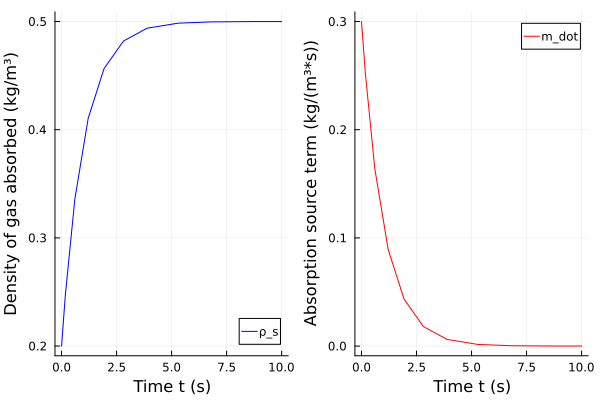

In [39]:
# problem set-up: right hand side function that defines the ODE
function rhs(u,p,t)
    return (0.5-u)                                           # Absorption assuming rho_{sat} = 0.5 and multiplying factors equal 1
end 

# problem set-up: initial condition
u0 = 0.2;                                                    # The solid contains already 20% of its maximum capacity

# problem set-up: set time span
Tend = 10                                                    # 10 time units
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
prob_abs = ODEProblem(rhs,u0,tspan)

# solve: perform time integration 
sol_abs = solve(prob_abs,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p_density_abs = plot(sol_abs.t, sol_abs.u, xlabel = "Time t (s)", ylabel = "Density of gas absorbed (kg/m³)", label ="ρ_s", line = :blue)

# post-process:evaluate and plot the source term 
p_mass_flow_rate = plot(sol_abs.t, rhs.(sol_abs.u,1,sol_abs.t), xlabel="Time t (s)",  ylabel = "Absorption source term (kg/(m³*s))", label = "m_dot",  line = :red)
plot(p_density_abs,p_mass_flow_rate,layout=(1,2))

Solver used: AutoVern7(Rodas5())

AutoVern7 is an adaptive Runge-Kutta method of 7th order that is efficient for moderately stiff problems. If the system becomes too stiff, the underlying implicit method, Rodas5, is automatically employed. Rodas5 is a specialized implicit solver designed for stiff systems, ensuring numerical stability when explicit methods might fail. This combination allows the solver to dynamically select the appropriate integration technique based on the problem's stiffness.

Stiffness in differential equations refers to the presence of widely varying timescales in a system, where some components change much faster than others. This makes explicit numerical methods inefficient, requiring very small time steps for stability, while implicit methods handle stiffness more efficiently by allowing larger time steps without instability.

**Interpretation** 

The plots show the evolution of hydrogen absorption in the solid material.

*Absorbed Gas Density $\rho_s(t)$*
- $\rho_s$ starts at 0.2 kg/m³ (initial condition) and gradually increases toward $\rho_{sat} = 0.5$ kg/m³.
- The curve follows an exponential-like growth, meaning absorption is initially fast but slows down as $\rho_s$ approaches equilibrium.

At the beginning, the material has a high capacity to absorb hydrogen because it is far from saturation.
As it gets filled, the absorption rate decreases, making the approach to equilibrium slower.
The system follows an exponential saturation behavior, similar to a first-order reaction.

*Absorption Rate $\dot{m}(t)$*
- $\dot{m}$ starts at a maximum value (~0.3 kg/m³/s) and rapidly decreases toward zero.
- The decrease is steepest at the beginning and then levels off over time.

Initially, hydrogen absorption is fast because the concentration gradient is high (large driving force).
Over time, as the solid becomes more saturated, the rate of absorption slows down.
When $\rho_s$ approaches $\rho_{sat} = 0.5$, $\dot{m} \to 0$, meaning no more hydrogen can be absorbed.



The results confirm the expected absorption dynamics: fast initial absorption, then gradual stabilizationas saturation is approached.
This validates the numerical model, ensuring correct implementation.

#### 2.2.1.2 Analytical solution

We solve the ordinary differential equation analytically:

$$
\frac{d\rho_s}{dt} = 0.5 - \rho_s
$$

Rearrange the equation:

$$
\frac{d\rho_s}{0.5 - \rho_s} = -dt
$$

Integrating both sides:

$$
\int \frac{d\rho_s}{0.5 - \rho_s} = \int -dt
$$

This gives:

$$
-\ln |0.5 - \rho_s| = t + C
$$

Rearrange:

$$
0.5 - \rho_s = C_1 e^{-t}
$$

where $C_1 = e^{-C}$ is a constant.

Given $\rho_s(0) = 0.2$:

$$
0.2 = 0.5 - C_1
$$

Solving for $C_1$:

$$
C_1 = 0.3
$$

The final solution is:
$$
\rho_s(t) = 0.5 - 0.3 e^{-t}
$$

This describes the time evolution of hydrogen density, approaching saturation $\rho_{sat} = 0.5$ as $t \to \infty$.


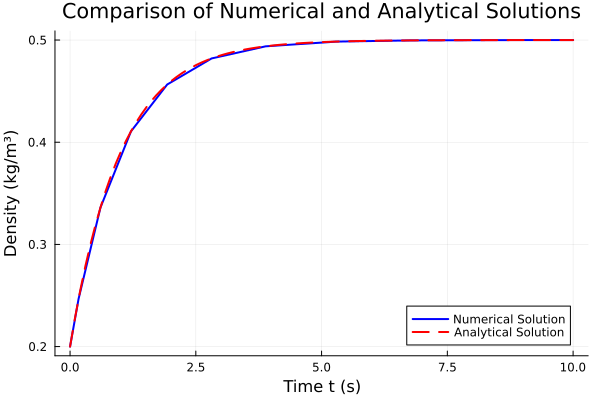

In [20]:
# Define the analytical solution function
function analytical_solution(t)
    return 0.5 - 0.3 * exp(-t)
end

# Generate time points for plotting the analytical solution
t_analytical = range(0, Tend, length=100)
rho_analytical = analytical_solution.(t_analytical)

# Plot both numerical and analytical solutions
plot(sol_abs.t, sol_abs.u, label="Numerical Solution", lw=2, line=:blue)
plot!(t_analytical, rho_analytical, label="Analytical Solution", lw=2, line=:red, linestyle=:dash)
xlabel!("Time t (s)")
ylabel!("Density (kg/m³)")
title!("Comparison of Numerical and Analytical Solutions")


### 2.2.2 Desorption Case

In the code, the desorption right-hand side function is defined as 

$$
\dot{m}_d = 0.1 \rho_s - 1
$$

Here, the term $0.1 \rho_s$ approximates how the desorption rate depends on the remaining stored hydrogen. The constant $0.1$ is a scaling factor chosen to adjust the influence of $\rho_s$ on the desorption rate. As $\rho_s$ approaches the empty bed density, the term $0.1 \rho_s$ decreases, which causes the overall desorption rate to become less negative. This means that when $u$ (representing $\rho_s$) is high, indicating a large amount of stored hydrogen, $\dot{m}_d = 0.1 u - 1$ is still very negative, so hydrogen is released quickly. Conversely, when $u$ is low, the desorption rate slows down as the system nears equilibrium. Although the constant $0.1$ is chosen arbitrarily here, in a more detailed model it could depend on physical factors such as temperature, pressure, and material properties.


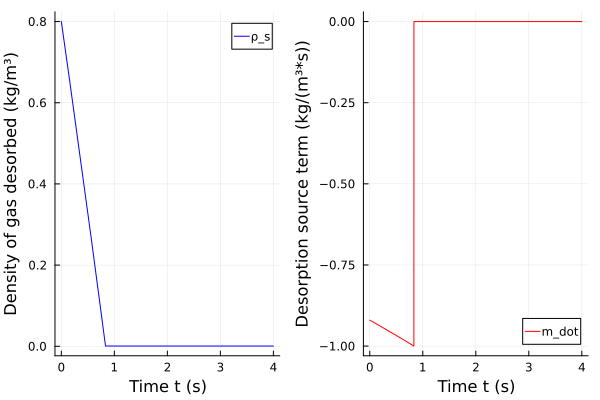

In [55]:
# problem set-up: rhs function that defines the ODE 
function rhs_d(u,p,t)
    return (0.1*u-1)*(u>0.001) 
    # The 1 here is a fixed offset, meaning that desorption is driven by a constant force rather than dynamically changing with pressure or remaining hydrogen density
    # The cutoff condition (u>0.001) ensures that when almost all hydrogen is released, desorption stops completely
end 

# problem set-up: initial condition 
u0_d = 0.8;

# problem set-up: set time span
Tend_d = 4
tspan = (0.0,Tend_d)

# problem set-up: define ODE problem 
prob_d = ODEProblem(rhs_d,u0_d,tspan)

# solve: perform time integration 
sol_d = solve(prob_d,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p_d_rho = plot(sol_d.t, sol_d.u, xlabel = "Time t (s)", ylabel = "Density of gas desorbed (kg/m³)", label ="ρ_s", line = :blue)

# post-process:evaluate and plot the source term 
p_d_mass_flow_rate = plot(sol_d.t, rhs_d.(sol_d.u,1,sol_d.t),xlabel="Time t (s)",  ylabel = "Desorption source term (kg/(m³*s))", label = "m_dot",  line = :red)
plot(p_d_rho,p_d_mass_flow_rate,layout=(1,2))

**Interpretation**

Left plot (Density of gas desorbed)drops almost instantly from 0.2 to near 0. This suggests a very fast desorption process, meaning the system is not progressively slowing down but rather emptying out all at once.

Right plot (Desorption source term), the mass flow rate is constant at -1 almost immediately, meaning hydrogen is being released at a constant and maximum rate until $\rho_s$ reaches zero.

In a realistic desorption model, the rate should gradually decrease as less hydrogen remains.
However, since "-1" is a constant term, the system immediately forces desorption at its maximum rate, making $\rho_s$ drops too quickly.
This is why the plot does not show an exponential decay like absorption.

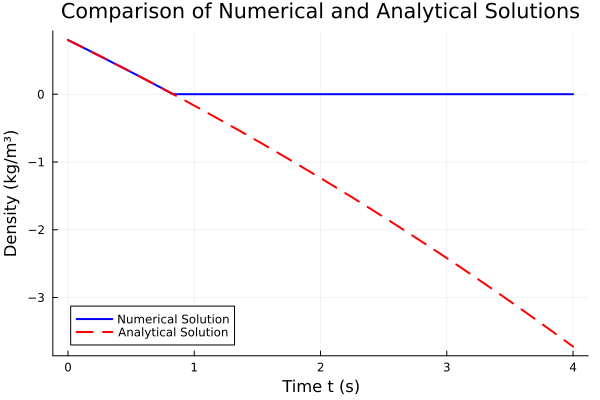

In [64]:
# Define the analytical solution function
function analytical_solution_dep(t)
    return 10 - 9.2*exp(t/10)
end

# Generate time points for plotting the analytical solution
t_analytical = range(0, Tend, length=100)
rho_analytical = analytical_solution_dep.(t_analytical)

# Plot both numerical and analytical solutions
plot(sol_d.t, sol_d.u, label="Numerical Solution", lw=2, line=:blue)
plot!(t_analytical, rho_analytical, label="Analytical Solution", lw=2, line=:red, linestyle=:dash)
xlabel!("Time t (s)")
ylabel!("Density (kg/m³)")
title!("Comparison of Numerical and Analytical Solutions")


### 2.2.3 Analyzing how parameters affect the system's behavior 

- Temperature $T$

A higher temperature generally accelerates desorption (hydrogen release) and slows down absorption due to the exponential dependence in the rate equations. This is because the activation energies $E_a$ and $E_d$ control the reaction rates, and increasing $T$ makes it easier for hydrogen to escape from the material.  

- Pressure $p_p$

A higher partial pressure of hydrogen favors absorption and hinders desorption, as seen in the logarithmic and fractional terms in the absorption/desorption equations. When $p_p$ is high, hydrogen is more likely to bind to the solid. Conversely, lowering $p_p$ below the equilibrium pressure promotes hydrogen release.  

By studying these dependencies, we can better understand the optimal conditions for efficient hydrogen storage and release, allowing for improved material performance and system design.  

---

First, I start by examining the temperature, as this is the easiest method to use.

The goal is to analyze how temperature $T$ influences the hydrogen absorption process in the metal hydride storage system. We remin that the governing equation for the absorption rate is:  

$$
\frac{d \rho_s}{dt} = C_a \exp\left(- \frac{E_a}{R T} \right) \log\left( \frac{p_p}{p_{eq,a}} \right) (\rho_{sat} - \rho_s)
$$

Accordgin to $Table-1$ :  
- $C_a = 590187$ s$^{-1}$ is the absorption rate constant.  
- $E_a = 21179.6$ J/mol is the activation energy.  
- $R = 8.314$ J/(mol·K) is the universal gas constant.  
- $\rho_{sat} = 7259$ kg/m³ is the maximum hydrogen storage density.

And :
- $\log(p_p / p_{eq,a}) = 1$ is assumed as a simplification.  
- $\rho_s(0) = 1000$ kg/m³ is the initial solid-phase hydrogen density.  

The simulation is performed for different temperatures:  

$$
T = 0, 10, 20, 50, 100, 150, 200^\circ C
$$

where $T$ is converted to Kelvin using $T_{\text{Kelvin}} = T_{\text{Celsius}} + 273.15$.

The absorption rate is computed using the exponential dependence on temperature:

$$
\text{absorption factor} = C_a \exp\left(-\frac{E_a}{R(T + 273.15)}\right) \log\left(\frac{p_p}{p_{eq,a}}\right)
$$

The ordinary differential equation is then solved numerically for each temperature, and the results are plotted on the same graph.

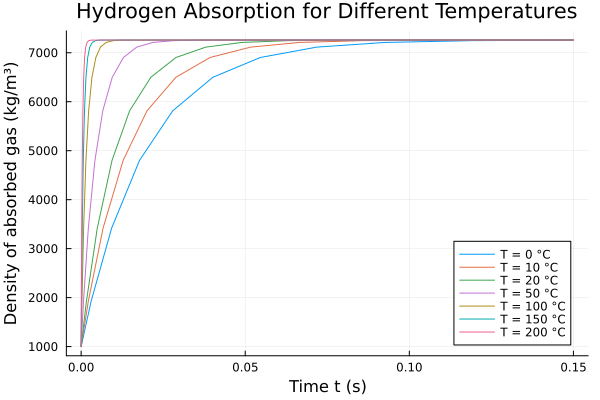

In [76]:
# Define constants
C_a = 590187          # Absorption rate constant (s^-1)
E_a = 21179.6         # Activation energy (J/mol)
R = 8.314             # Gas constant (J/(mol·K))
rho_sat = 7259        # Saturated density of solid phase (kg/m³)
log_pressure_term = 1 # Assumed value

# Define temperature values in Celsius
T_values = [0, 10, 20, 50, 100, 150, 200]  

# Set initial condition
u0 = 1000  # Initial solid-phase hydrogen density (kg/m³)

# Define time span
Tend = 0.15
tspan = (0.0, Tend)

# Define a function to compute the absorption rate for a given temperature
function absorption_rhs(u, T)
    absorption_factor = C_a * exp(-E_a / (R * (T + 273.15))) * log_pressure_term
    return absorption_factor * (rho_sat - u)
end

# Solve ODE for each temperature and plot results
p = plot(title="Hydrogen Absorption for Different Temperatures", xlabel="Time t (s)", ylabel="Density of absorbed gas (kg/m³)")

for T in T_values
    function rhs(u, p, t)
        return absorption_rhs(u, T)
    end

    prob_abs = ODEProblem(rhs, u0, tspan)
    sol_abs = solve(prob_abs, AutoVern7(Rodas5()), reltol=1e-4, abstol=1e-4)

    plot!(p, sol_abs.t, sol_abs.u, label="T = $T °C")
end

display(p)


The higher the temperature, the faster the absorption occurs, meaning the solid reaches its saturation density $\rho_{sat}$ more quickly.
This is because higher temperatures increase reaction rates (exponential dependence on T in the absorption equation).

By comparing the solutions, we observe that:
- The higher the temperature, the faster the absorption occurs, meaning the solid reaches its saturation density $\rho_{sat}$ more quickly.
This is because higher temperatures increase reaction rates (exponential dependence on T in the absorption equation).
- At lower temperatures, absorption takes longer, as the activation energy barrier slows the reaction
- The temperature dependence follows an Arrhenius-type behavior, where reaction rates increase exponentially with temperature.

This study helps to understand the optimal conditions for hydrogen storage efficiency and the impact of temperature on material performance.

# Section 3: Solid/Gas Density in Spatially Homogenous Reactor

**Asumptions** : same as before 

We model the time evolution of:
1. $\rho_s(t)$: The density of hydrogen absorbed in the metal-oxide solid.
2. $\rho_g(t)$: The density of gaseous hydrogen in the reactor.

These two quantities are coupled because when hydrogen is absorbed into the solid, it is removed from the gas phase, and when it is desorbed, it is released back into the gas.

**Problem Formulation** 
The governing equations are:

$$
(1 - \epsilon) \frac{d \rho_s}{dt} = \dot{m}(\rho_s, t), \quad \text{with} \quad \rho_s(0) = \rho_{s,0}
$$

$$
\epsilon \frac{d \rho_g}{dt} = - \dot{m}(\rho_s, t), \quad \text{with} \quad \rho_g(0) = \rho_{g,0}
$$


- $(1 - \epsilon)$ represents the fraction of the reactor volume occupied by the solid, while $\epsilon$ is the fraction occupied by gas.
- The rate of change of $\rho_s$ depends on the absorption/desorption rate $\dot{m}(\rho_s, t)$.
- The negative sign in the equation for $\rho_g$ ensures mass conservation: when hydrogen is absorbed into the solid, it leaves the gas phase, and vice versa.

**Physical interpretation**
- For absorption: $\dot{m} > 0$ leads to an increase in $\rho_s$ and a decrease in $\rho_g$.
- For desorption: $\dot{m} < 0$ leads to a decrease in $\rho_s$ and an increase in $\rho_g$.

**Boundary Conditions**
- $\rho_s(0)$: The initial solid-phase hydrogen density. It could be set to $\rho_{sat}$ if the reactor starts fully loaded or to $\rho_{emp}$ if it starts empty.
- $\rho_g(0)$: The initial gas-phase hydrogen density. If the reactor is pressurized, $\rho_g(0)$ is nonzero; if it starts in a vacuum, $\rho_g(0) = 0$.

**Code**

The next step is to extend the previous model from a single ordinary differential equation to a coupled system. The implementation should update both $\rho_s$ and $\rho_g$ and visualize how they evolve over time.


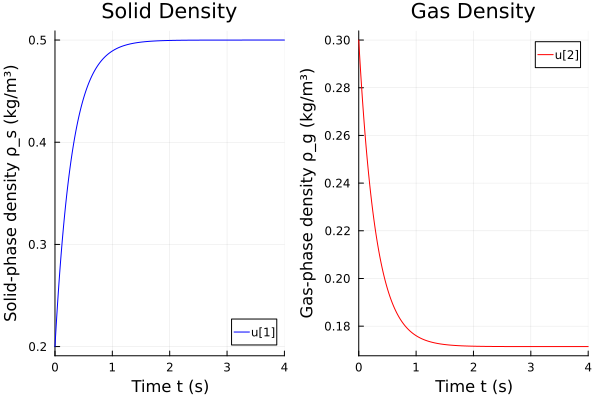

In [117]:
# problem set-up: rhs function that defines the ODE 
function rhs!(du,u,p,t)
    mdot = (.5-u[1])
    epsilon = 0.7 
    du[1] = mdot/(1-epsilon)  # Solid-phase density evolution
    du[2] = -mdot/epsilon     # Gas-phase density evolution
end

# problem set-up: initial condition
u0 = [0.2,0.3] 

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem
prob = ODEProblem(rhs!,u0,tspan)

# solve: perform time integration
sol = solve(prob)

# post-process: plot computed solution
p1 = plot(sol, idxs=1, line = :blue, title="Solid Density",
          xlabel="Time t (s)", ylabel="Solid-phase density ρ_s (kg/m³)")

p2 = plot(sol, idxs=2, line = :red, title="Gas Density",
          xlabel="Time t (s)", ylabel="Gas-phase density ρ_g (kg/m³)")

plot(p1, p2, layout = (1,2))


The plots represent the evolution of hydrogen density in the solid phase $\rho_s$ and gas phase $\rho_g$ over time in a spatially homogeneous reactor.  

- **Solid Density ($\rho_s$) (left plot)**:  
  - Starts at an initial value of 0.2 and increases over time.  
  - Approaches its saturation value of 0.5 as absorption progresses.  
  - The rate of increase slows down as $\rho_s$ nears saturation.  

- **Gas Density ($\rho_g$) (right plot)**:  
  - Starts at an initial value of 0.3 and decreases over time.  
  - This decrease is due to the absorption of hydrogen into the solid phase.  
  - As absorption slows, $\rho_g$ stabilizes at a lower value.  

The equations governing the system show that the mass flow rate $\dot{m}$ is proportional to the difference between the saturated solid density and the current value of $\rho_s$. The system reaches equilibrium when $\rho_s$ is fully saturated and $\rho_g$ no longer significantly decreases.  


# Section 4: Solid/Gas Density with in 1D Plug Flow Reactor 

<b>Assumptions</b>:
1. assume reactor to extend in space along the $z$-axis of a cylindrical coordinate system from $z=0$ to $z = 0.8 \, \text{m}$. 
2. assume $z$-axis to be discretized using an uniform mesh; 
3. assume constant flow $u_z$ (in $\text{m}/\text{s}$) around the $z$-axis; 

<b>Problem Formulation</b>:

We assume the velocity $u_z(z)$ to be known (a-priori given). 

$$
(1 - \epsilon) \frac{\partial \, \rho_s}{\partial t} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} 
\text{ and boundary conditions} \,    
$$

and 

$$
\epsilon \frac{\partial \, \rho_g}{\partial t} = 
D \, \frac{\partial^2 \, \rho_g}{\partial z^2}
+ u_z \, \frac{\partial \, \rho_g}{\partial z} 
+ \dot{m}(\rho_s, t) 
\text{ given } \rho_g(t = 0) = \rho_{g,0} 
\text{ and boundary conditions} \, .     
$$


<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space: discretize the diffusion using second-order three-point finite difference stencil (tri-diagonal matrix $S$) and first-order two-point convection (bi-diagonal matrix $C$) operator using finite differences on a uniform mesh. Alternatively, use [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) in space and time. 

For <b>discretization</b> in time: using DifferentialEquations.jl as before. See e.g. [EE4375 course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) for examples. Or use e.g. [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) (observe that Ferrite ha no stabilization methods for convection dominated flows, assume no stabilization require for laminar flow through porous media); 

## Section 4.1: Steady State: Convection-Diffusion Equation for Gas Density $\rho_g$

We solve the steady-state convection-diffusion equation for gas density $\rho_g(x)$ along the reactor:

$$
D \frac{d^2 \rho_g}{dz^2} + u_z \frac{d \rho_g}{dz} + \dot{m} = 0
$$

where:
- $D$ is the diffusion coefficient,
- $u_z$ is the velocity along the reactor,
- $\dot{m}$ represents the absorption/desorption term, and $ (\dot{m} = 0) $ because it is a steady state
- $\rho_g$ is the gas density.


--- 
**ANALYTICAL RESOLUTION** 


We assume a solution of the form:

$$
\rho_g(x) = e^{\lambda x}
$$

Substituting into the equation:

$$
D \lambda^2 e^{\lambda x} + u_z \lambda e^{\lambda x} = 0
$$

Dividing by $ e^{\lambda x} $ (which is never zero):

$$
D \lambda^2 + u_z \lambda = 0
$$

Solving for $ \lambda $:

$$
\lambda = 0 \quad \text{or} \quad \lambda = -\frac{u_z}{D}
$$

Thus, the general solution is:

$$
\rho_g(x) = C_1 + C_2 e^{- \frac{u_z}{D} x}
$$

We use Dirichlet boundary conditions:

$$
\rho_g(0) = 1, \quad \rho_g(L) = 0
$$

Setting $ x = 0 $:

$$
1 = C_1 + C_2
$$

Setting $ x = L = 0.8 $:

$$
0 = C_1 + C_2 e^{- \frac{u_z}{D} \cdot 0.8}
$$

$$
C_1 = 1- \frac{1}{1 - e^{-\frac{u_z}{D} L}}, \quad C_2 = \frac{1}{1 - e^{-\frac{u_z}{D} L}}
$$

Thus, the final analytical solution is:

$$
\rho_g(z) = \frac{-e^{-\frac{u_z}{D} L}}{1 - e^{-\frac{u_z}{D} L}} + \frac{e^{-\frac{u_z}{D} z}}{1 - e^{-\frac{u_z}{D} L}}
$$


--- 
**NUMERICAL RESOLUTION** 

To transform this second-order equation into a system of first-order equations, we define:

$$
v(z) = \frac{d \rho_g}{dz}
$$

which leads to:

$$
\frac{d \rho_g}{dz} = v
$$

$$
\frac{dv}{dz} = -\frac{u_z}{D} v - \frac{\dot{m}}{D}
$$


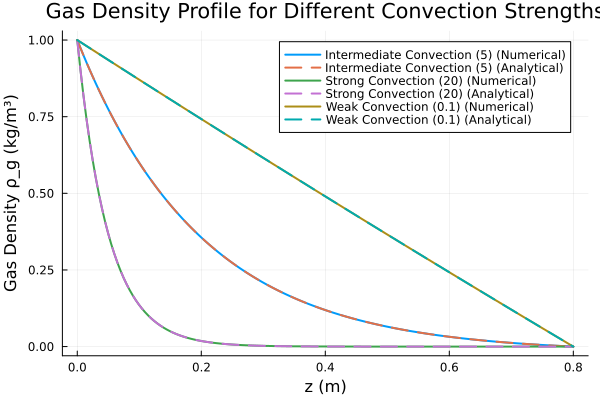

In [5]:
# Set right-hand side function for the ODE system
function rhs!(du, u, p, x)
    rhog = u[1]                                             # Gas density ρ_g(x) [kg/m³]
    rho_g_deriv = u[2]                                      # Gradient of gas density (dρ_g/dx) [kg/m⁴] 

    convection_strength = p[1]                              # Parameter to control convection strength
    
    du[1] = rho_g_deriv
    du[2] = (-convection_strength/D) * rho_g_deriv              # Convection-diffusion equation
end

# Set boundary conditions
function bc(residual, u, p, x)
    rhogleft = 1.0; rhogright = 0.0
    residual[1] = u[1][1] - rhogleft                        # Dirichlet BC at z = 0
    residual[2] = u[end][1] - rhogright                     # Dirichlet BC at z = L
end

# Set domain size 
L = 0.8                 # Reactor length in meters
zspan = (0., L)

# Set initial guess
start = [0., 0.]

# Define convection strengths to be tested
convection_cases = Dict(
    "Weak Convection (0.1)" => 0.1, 
    "Intermediate Convection (5)" => 5, 
    "Strong Convection (20)" => 20
)

# Diffusion coefficient
D = 1 

# Initialize plot
p1 = plot(title="Gas Density Profile for Different Convection Strengths", xlabel="z (m)", ylabel="Gas Density ρ_g (kg/m³)", legend=:topright)

# Solve for each case and plot numerical and analytical solutions
for (label, conv_strength) in convection_cases
    # Set convection parameter
    p = [conv_strength]

    # Define and solve the boundary value problem
    bvp = BVProblem(rhs!, bc, start, zspan, p)
    sol = solve(bvp, MIRK4(), dt = 0.005)

    # Extract numerical gas density solution
    rhog_values  = [u[1] for u in sol.u]

    # Compute analytical solution
    x_vals = sol.t  # Spatial points

    # Analytical solution using corrected formula
    C2 = 1 / (1 - exp(-conv_strength * L / D))
    C1 = -exp(-conv_strength * L / D) / (1 - exp(-conv_strength * L / D))
    analytical_solution = [C1 + C2 * exp(-conv_strength * x / D) for x in x_vals]

    # Plot numerical solution
    plot!(x_vals, rhog_values, label=label * " (Numerical)", linewidth=2)

    # Plot analytical solution as dashed line
    plot!(x_vals, analytical_solution, linestyle=:dash, label=label * " (Analytical)", linewidth=2)
end

# Display the final plot
display(p1)


Here we analyze the steady-state gas density profile $\rho_g(z)$ along the reactor length $z$ for different convection strengths. The reactor extends from $z = 0$ to $z = 0.8$ m, with boundary conditions $\rho_g(0) = 1$ (gas enters at maximum density) and $\rho_g(0.8) = 0$.

- **Weak convection** $u_z = 0.1$ (green curve): The density decreases nearly linearly, indicating that diffusion dominates over convection. The gas spreads uniformly before exiting.  
- **Intermediate convection** $u_z = 5$ (blue curve): The density drops faster, showing that both convection and diffusion contribute. Gas transport is accelerated but still smooth.  
- **Strong convection** $u_z = 20$ (red curve): The density falls very sharply, meaning gas is rapidly transported with little diffusion. The system is convection-dominated.

When convection is weak, the gas has time to diffuse, leading to a gradual transition. As convection increases, transport is faster, creating steeper gradients.

For now, we focus on the weak convection case to study diffusion-dominated behavior in more detail.  
Later, we will explore how strong convection could be an asset in optimizing hydrogen transport efficiency.

Use [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) in space to verify this solution. Implement weak, intermediate and strong convection.

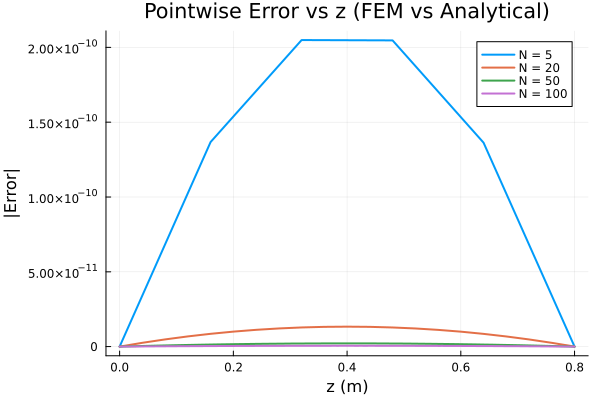

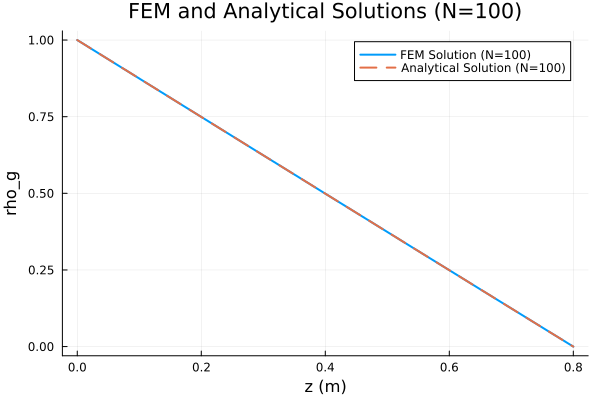

In [7]:
# Problem parameters
L = 0.8
D = 1.0
uz = 0.01
m_dot = 0.0
N_list = [5, 20, 50, 100]  # Mesh sizes to test

# Initialize plot for pointwise errors vs z
p = plot(title="Pointwise Error vs z (FEM vs Analytical)",
    xlabel="z (m)", ylabel="|Error|", lw=2, legend=:topright)

# Initialize plot for FEM and Analytical solution for N = 100
p_solutions = plot(title="FEM and Analytical Solutions (N=100)",
    xlabel="z (m)", ylabel="rho_g", lw=2, legend=:topright)

for N in N_list
    interpolation = Lagrange{RefLine, 1}()
    qr = QuadratureRule{RefLine}(2)
    cell_values = CellValues(qr, interpolation)

    # Définition précise du domaine
    left = Vec((0.,))
    right = Vec((L,))
    grid = generate_grid(Line, (N,), left, right)

    dh = DofHandler(grid)
    add!(dh, :rho_g, interpolation)
    close!(dh)

    K = allocate_matrix(dh)
    f = zeros(ndofs(dh))

    function assemble!(K, f, cv, dh, D, uz, m_dot)
        assembler = start_assemble(K, f)
        for cell in CellIterator(dh)
            Ferrite.reinit!(cv, cell)
            n_basefuncs = getnbasefunctions(cv)
            Ke = zeros(n_basefuncs, n_basefuncs)
            fe = zeros(n_basefuncs)
            for q in 1:getnquadpoints(cv)
                dΩ = getdetJdV(cv, q)
                for i in 1:n_basefuncs
                    ϕ = shape_value(cv, q, i)
                    ∇ϕ = shape_gradient(cv, q, i)[1]
                    for j in 1:n_basefuncs
                        ∇ϕ_j = shape_gradient(cv, q, j)[1]
                        Ke[i, j] += (D * ∇ϕ * ∇ϕ_j - uz * ϕ * ∇ϕ_j) * dΩ
                    end
                    fe[i] += m_dot * ϕ * dΩ
                end
            end
            Ferrite.assemble!(assembler, celldofs(cell), Ke, fe)
        end
    end

    assemble!(K, f, cell_values, dh, D, uz, m_dot)

    ch = ConstraintHandler(dh)
    dbc1 = Dirichlet(:rho_g, [1], (x, t) -> 1.0)
    dbc2 = Dirichlet(:rho_g, [ndofs(dh)], (x, t) -> 0.0)
    add!(ch, dbc1)
    add!(ch, dbc2)
    close!(ch)
    
    apply!(K, f, ch)

    rho_g = K \ f

    # Utilisation des fonctions Ferrite pour l'évaluation aux nœuds
    rho_g_computed_at_nodes = evaluate_at_grid_nodes(dh, rho_g, :rho_g)

    conv_strength = uz / D
    C2 = 1 / (1 - exp(-conv_strength * L))
    C1 = -exp(-conv_strength * L) / (1 - exp(-conv_strength * L))

    rho_g_anal(x::Vec) = C1 + C2 * exp(-conv_strength * x[1])
    rho_g_anal(node::Node) = rho_g_anal(node.x)

    # Initialisation du vecteur contenant la solution analytique
    rho_g_analytical = zeros(ndofs(dh))

    # Application de la solution analytique aux DDL
    apply_analytical!(rho_g_analytical, dh, :rho_g, rho_g_anal)

    # Evaluation de la solution analytique aux nœuds
    rho_g_analytical_at_nodes = evaluate_at_grid_nodes(dh, rho_g_analytical, :rho_g)

    # Calcul des erreurs ponctuelles
    pointwise_errors = abs.(rho_g_computed_at_nodes - rho_g_analytical_at_nodes)

    # Génération des coordonnées z à partir des nœuds du maillage
    z_coords = [grid.nodes[node].x[1] for node in 1:length(grid.nodes)]

    # Plot pointwise errors vs z
    plot!(p, z_coords, pointwise_errors, label="N = $N", lw=2)

    if N == 100
        plot!(p_solutions, z_coords, rho_g_computed_at_nodes, label="FEM Solution (N=100)", lw=2)
        plot!(p_solutions, z_coords, rho_g_analytical_at_nodes, label="Analytical Solution (N=100)", lw=2, linestyle=:dash)
    end
end

# Display plots
display(p)
display(p_solutions)

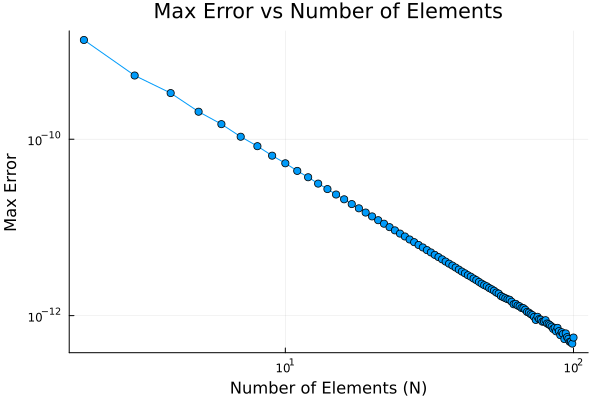

In [8]:
# Problem parameters
L = 0.8
D = 1.0
uz = 0.01
m_dot = 0.0
N_list = 2:100  # Mesh sizes to test

# Initialize plot for max error vs number of elements
p = plot(title="Max Error vs Number of Elements",
         xlabel="Number of Elements (N)", ylabel="Max Error",
         xscale=:log10, yscale=:log10, lw=2, legend=false)

max_errors = []
num_elements = []

for N in N_list
    interpolation = Lagrange{RefLine, 1}()
    qr = QuadratureRule{RefLine}(2)
    cell_values = CellValues(qr, interpolation)

    # Définition précise du domaine
    left = Vec((0.,))
    right = Vec((L,))
    grid = generate_grid(Line, (N,), left, right)

    dh = DofHandler(grid)
    add!(dh, :rho_g, interpolation)
    close!(dh)

    K = allocate_matrix(dh)
    f = zeros(ndofs(dh))

    function assemble!(K, f, cv, dh, D, uz, m_dot)
        assembler = start_assemble(K, f)
        for cell in CellIterator(dh)
            Ferrite.reinit!(cv, cell)
            n_basefuncs = getnbasefunctions(cv)
            Ke = zeros(n_basefuncs, n_basefuncs)
            fe = zeros(n_basefuncs)
            for q in 1:getnquadpoints(cv)
                dΩ = getdetJdV(cv, q)
                for i in 1:n_basefuncs
                    ϕ = shape_value(cv, q, i)
                    ∇ϕ = shape_gradient(cv, q, i)[1]
                    for j in 1:n_basefuncs
                        ∇ϕ_j = shape_gradient(cv, q, j)[1]
                        Ke[i, j] += (D * ∇ϕ * ∇ϕ_j - uz * ϕ * ∇ϕ_j) * dΩ
                    end
                    fe[i] += m_dot * ϕ * dΩ
                end
            end
            Ferrite.assemble!(assembler, celldofs(cell), Ke, fe)
        end
    end

    assemble!(K, f, cell_values, dh, D, uz, m_dot)

    ch = ConstraintHandler(dh)
    dbc1 = Dirichlet(:rho_g, [1], (x, t) -> 1.0)
    dbc2 = Dirichlet(:rho_g, [ndofs(dh)], (x, t) -> 0.0)
    add!(ch, dbc1)
    add!(ch, dbc2)
    close!(ch)
    apply!(K, f, ch)

    rho_g = K \ f

    # Utilisation des fonctions Ferrite pour l'évaluation aux nœuds
    rho_g_computed_at_nodes = evaluate_at_grid_nodes(dh, rho_g, :rho_g)

    conv_strength = uz / D
    C2 = 1 / (1 - exp(-conv_strength * L))
    C1 = -exp(-conv_strength * L) / (1 - exp(-conv_strength * L))

    rho_g_anal(x::Vec) = C1 + C2 * exp(-conv_strength * x[1])
    rho_g_anal(node::Node) = rho_g_anal(node.x)

    # Initialisation du vecteur contenant la solution analytique
    rho_g_analytical = zeros(ndofs(dh))

    # Application de la solution analytique aux DDL
    apply_analytical!(rho_g_analytical, dh, :rho_g, rho_g_anal)

    # Evaluation de la solution analytique aux nœuds
    rho_g_analytical_at_nodes = evaluate_at_grid_nodes(dh, rho_g_analytical, :rho_g)

    # Calcul des erreurs ponctuelles
    pointwise_errors = abs.(rho_g_computed_at_nodes - rho_g_analytical_at_nodes)

    # Calcul de l'erreur maximale
    max_error = maximum(pointwise_errors)
    push!(max_errors, max_error)
    push!(num_elements, N)
end

# Plot max error vs number of elements
plot!(p, num_elements, max_errors, marker=:circle)

# Display plot
display(p)

---

When $ u_z $ is small (e.g., $ u_z \leq 0.01 $), the equation is diffusion-dominated. In this case, the finite element method (FEM) works well, and the solution is accurate.

When $ u_z $ increases, the problem becomes convection-dominated, which creates numerical issues:

1. Numerical Instabilities  
   - Standard FEM does not include stabilization.  
   - For large $ u_z $, the solution oscillates instead of following the expected exponential decay.  

2. Artificial Diffusion 
   - FEM without stabilization introduces excessive diffusion, making the solution too smooth.  
   - The boundary layer at $ z = L $ is not well captured.  

3. Need for Stabilization
   - Finite difference methods use upwinding to fix this issue.  
   - FEM requires SUPG (Streamline Upwind Petrov-Galerkin) or discontinuous Galerkin (DG-FEM) for stabilization.  

## Section 4.2: Transient Model 

### 4.2.1 Convection-Diffusion Equation for Gas Density $\rho_g$

We now consider the time-dependent convection-diffusion equation for gas density $ \rho_g(z, t) $ along the reactor:

$$
\frac{\partial \rho_g}{\partial t} = D \frac{\partial^2 \rho_g}{\partial z^2} + u_z \frac{\partial \rho_g}{\partial z} + \dot{m}
$$

where:
- $ D $ is the diffusion coefficient,
- $ u_z $ is the velocity along the reactor,
- $ \dot{m} $ represents the absorption/desorption term, which we set to **zero** for simplicity,
- $ \rho_g(z, t) $ is the gas density, which varies with **time**.

---

**ANALYTICAL RESOLUTION** 

We assume a separable solution of the form:

$$
\rho_g(z,t) = X(z)T(t)
$$

Substituting into the equation:

$$
T'(t) X(z) = D X''(z)T(t) + u_z X'(z)T(t)
$$

Dividing by $ X(z)T(t) $:

$$
\frac{T'(t)}{T(t)} = D \frac{X''(z)}{X(z)} + u_z \frac{X'(z)}{X(z)}
$$

Since the left-hand side depends only on time and the right-hand side only on space, both must equal a separation constant $ \lambda $, which must be **negative** since we expect a decaying transient solution :

$$
\frac{T'(t)}{T(t)} = \lambda
$$

$$
D X''(z) + u_z X'(z) - \lambda X(z) = 0
$$

Thus, the time-dependent part satisfies:

$$
T(t) = e^{\lambda t}
$$

and the spatial part satisfies:

$$
D X''(z) + u_z X'(z) - \lambda X(z) = 0
$$

The solution for $ X(z) $ follows:

$$
r_{1,2} = \frac{- u_z \pm \sqrt{u_z^2 + 4D\lambda}}{2D}
$$

Thus, the general solution for the transient case is:
$$
X(z) = C_1 e^{r_1 z} + C_2 e^{r_2 z}
$$

We impose Dirichlet boundary conditions:

$$
\rho_g(0,t) = 1 \Rightarrow X(0) T(t) = 1
$$

$$
\rho_g(L,t) = 0 \Rightarrow X(L) T(t) = 0
$$

At $ z = 0 $:

$$
C_1 + C_2 = 1
$$

At $ z = L$:

$$
C_1 e^{r_1 L} + C_2 e^{r_2 L} = 0
$$

Substituting $ C_2 = 1 - C_1$:

$$
C_1 e^{r_1 L} + (1 - C_1) e^{r_2 L} = 0
$$

Solving for $ C_1 $:

$$
C_1 = \frac{e^{r_2 L}}{e^{r_2 L} - e^{r_1 L}}
$$

Thus:

$$
C_2 = \frac{- e^{r_1 L}}{e^{r_2 L} - e^{r_1 L}}
$$


So the final analytical solution is :

$$
\rho_g(z, t) = \left( \frac{e^{r_2 L} e^{r_1 z} - e^{r_1 L} e^{r_2 z}}{e^{r_2 L} - e^{r_1 L}} \right) e^{\lambda t}
$$

Where:

$$
r_{1,2} = \frac{- u_z \pm \sqrt{u_z^2 + 4D\lambda}}{2D}
$$

The values of $ \lambda$ are determined by solving the characteristic equation numerically.

---

**NUMERICAL RESOLUTION** 

To transform this second-order equation into a system of first-order equations, we define:

$$
v(z,t) = \frac{\partial \rho_g}{\partial z}
$$

$$
\frac{\partial \rho_g}{\partial t} = D \frac{\partial v}{\partial z} + u_z v
$$

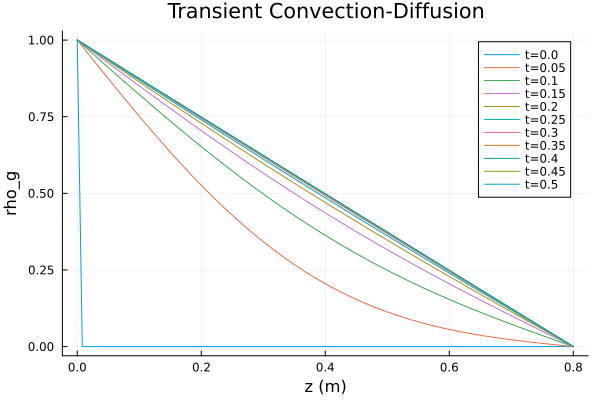

In [4]:
# Parameters
L = 0.8
D = 1.0
uz = 0.01
N = 100 # Number of spatial points
zspan = (0.0, L)
tspan = (0.0, 0.5) # Time span

# Spatial discretization
dz = L / (N - 1)
z_coords = LinRange(0, L, N)

# Initial condition
u0 = zeros(N)
u0[1] = 1.0 # rho_g(0, 0) = 1

# Right-hand side function for the ODE system
function rhs!(du, u, p, t)
    N = length(u)
    du .= 0.0 # Initialize du to zero

    # Boundary conditions
    u[1] = 1.0
    u[end] = 0.0

    # Calculate v (d(rho_g)/dz) using finite differences
    v = zeros(N)
    for i in 2:(N-1)
        v[i] = (u[i+1] - u[i-1]) / (2 * dz)
    end
    v[1] = (u[2] - u[1]) / dz
    v[end] = (u[end] - u[end-1]) / dz

    # Calculate d(rho_g)/dt
    for i in 2:(N-1)
        du[i] = D * (v[i+1] - v[i-1]) / (2 * dz) + uz * v[i]
    end
    du[1] = D * (v[2] - v[1]) / dz + uz * v[1]
    du[end] = D * (v[end] - v[end-1]) / dz + uz * v[end]
end

# ODE problem definition and solution
prob = ODEProblem(rhs!, u0, tspan)
sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-8, saveat=0.05)

# Plotting
p1 = plot(title="Transient Convection-Diffusion", xlabel="z (m)", ylabel="rho_g")
for t in sol.t
    plot!(p1, z_coords, sol(t), label="t=$(round(t, digits=2))")
end
display(p1)

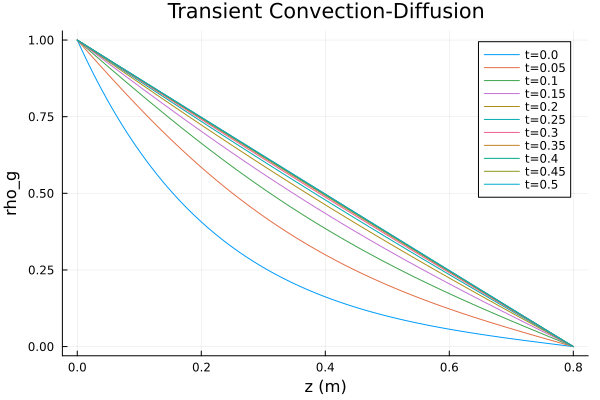

In [16]:
# Problem parameters
L = 0.8
D = 1.0
uz = 0.01
m_dot = 0.0
N = 100
zspan = (0.0, L)
tspan = (0.0, 0.5) # Time span

# Quadrature et Interpolation
interpolation = Lagrange{RefLine, 1}()
qr = QuadratureRule{RefLine}(2)
cell_values = CellValues(qr, interpolation)

# Définition précise du domaine et ddl
left = Vec((0.,))
right = Vec((L,))
grid = generate_grid(Line, (N,), left, right)

dh = DofHandler(grid)
add!(dh, :rho_g, interpolation)
close!(dh)

K = allocate_matrix(dh)
C = allocate_matrix(dh)
M = allocate_matrix(dh)
f = zeros(ndofs(dh))

# Conditions aux limites
T = 0.5
Δt = 0.05 # Time step

ch = ConstraintHandler(dh)
dbc1 = Dirichlet(:rho_g, [1], (x, t) -> 1.0)
dbc2 = Dirichlet(:rho_g, [ndofs(dh)], (x, t) -> 0.0)
add!(ch, dbc1)
add!(ch, dbc2)
close!(ch)

function assemble_Kf!(K, f, cv, dh, D, uz) #cette fonction créer la matrice K et le vecteur f
    assembler = start_assemble(K, f)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cv, cell)
        n_basefuncs = getnbasefunctions(cv)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)
        for q in 1:getnquadpoints(cv)
            dΩ = getdetJdV(cv, q)
            for i in 1:n_basefuncs
                ϕ = shape_value(cv, q, i)
                ∇ϕ = shape_gradient(cv, q, i)[1]
                fe[i] += m_dot * ϕ * dΩ
                for j in 1:n_basefuncs
                    ∇ϕ_j = shape_gradient(cv, q, j)[1]
                    Ke[i, j] += (D * ∇ϕ * ∇ϕ_j) * dΩ
                end
            end
        end
        Ferrite.assemble!(assembler, celldofs(cell), Ke, fe)
    end
end

function assemble_C!(C, cv, dh, uz) #cette fonction créer la matrice C
    assembler = start_assemble(C)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cv, cell)
        n_basefuncs = getnbasefunctions(cv)
        Ce = zeros(n_basefuncs, n_basefuncs)
        for q in 1:getnquadpoints(cv)
            dΩ = getdetJdV(cv, q)
            for i in 1:n_basefuncs
                ϕ = shape_value(cv, q, i)
                ∇ϕ = shape_gradient(cv, q, i)[1]
                for j in 1:n_basefuncs
                    ∇ϕ_j = shape_gradient(cv, q, j)[1]
                    Ce[i, j] += (-uz * ϕ * ∇ϕ_j) * dΩ
                end
            end
        end
        Ferrite.assemble!(assembler, celldofs(cell), Ce)
    end
end

function assemble_M!(M, cv, dh) #cette fonction créer la matrice M
    assembler = start_assemble(M)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cv, cell)
        n_basefuncs = getnbasefunctions(cv)
        Me = zeros(n_basefuncs, n_basefuncs)
        for q in 1:getnquadpoints(cv)
            dΩ = getdetJdV(cv, q)
            for i in 1:n_basefuncs
                ϕ = shape_value(cv, q, i)
                for j in 1:n_basefuncs
                    Me[i, j] += ϕ * shape_value(cv, q, j) * dΩ
                end
            end
        end
        Ferrite.assemble!(assembler, celldofs(cell), Me)
    end
end

assemble_Kf!(K, f, cell_values, dh, D, uz)
assemble_C!(C, cell_values, dh, uz)
assemble_M!(M, cell_values, dh)

A = M + Δt*(K + C);
rhsdata = get_rhs_data(ch, A) # save all boundary condition related values of the unaltered system matrix A

# Initial time step,
uₙ = zeros(ndofs(dh));

function apply_analytical!(u, dh)
    z_coords = [grid.nodes[i].x[1] for i in 1:length(grid.nodes)]
    for (i, z) in enumerate(z_coords)
        if z == 0.0
            u[i] = 1.0
        else
            u[i] = 0.0
        end
    end
    return u
end

uₙ = apply_analytical!(uₙ, dh);

apply!(A, ch);

# Time loop
results = []
times = []
for (step, t) in enumerate(0.0:Δt:T)
    #First of all, we need to update the Dirichlet boundary condition values.
    update!(ch, t)

    #Secondly, we compute the right-hand-side of the problem.
    b = M * uₙ + Δt*f;

    #Then, we can apply the boundary conditions of the current time step.
    apply_rhs!(rhsdata, b, ch)

    #Finally, we can solve the time step and save the solution afterwards.
    u = A \ b

    # Save the solution every 0.05 seconds
    push!(results, copy(u))
    push!(times, t)

    #At the end of the time loop, we set the previous solution to the current one and go to the next time step.
    uₙ .= u
end

#plot the result
z_coords = [grid.nodes[i].x[1] for i in 1:length(grid.nodes)]
p = plot(title="Transient Convection-Diffusion", xlabel="z (m)", ylabel="rho_g")

for (i, t) in enumerate(times)
    plot!(p, z_coords, results[i], label="t=$(round(t, digits=2))")
end
display(p)

### 4.2.2 Convection-Diffusion Equation for Gas and Solid Densities

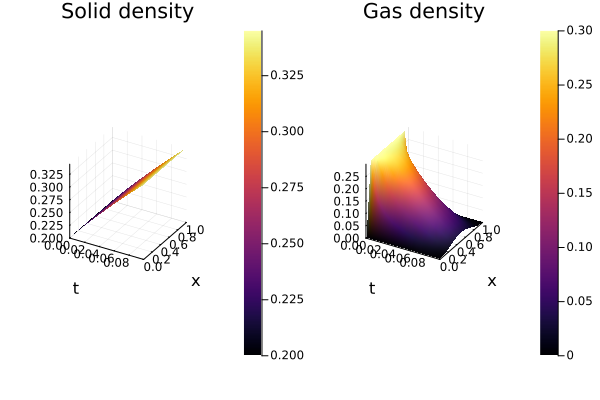

In [11]:
p = []  # If no parameters are needed, set p as an empty array

# Spatial discretization
N = (10,); Np1 = N[1]+1
m = fdmmesh(N)
A = stiffmat(m)
C = convectionmat(m)

# ODE model function
function plug_flow_reactor!(du,u,p,t)
    Np1         = length(u) ÷ 2 
    rhog        = @view u[Np1+1:end]
    mdot        = 1 .- rhos
    epsilon     = 0.5 
    du[1:Np1]  .= mdot/(1-epsilon)  
    du[Np1+1:end] .= -A*rhog - mdot/epsilon 
    du[Np1+1] = 0; du[end] = 0 
end

# Initial conditions
rhos0 = [.2 for xi in m[1]]
rhog0 = [.3 for xi in m[1]]; rhog0[1] = 0.; rhog0[end] = 0.;  
u0  = [rhos0; rhog0]

# Time interval
tspan = (0.0,0.1)

# Define and solve the problem (now with correctly defined p)
prob = ODEProblem(plug_flow_reactor!, u0, tspan, p)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true)

# Post-processing 
rhosmat = reduce(hcat,[uti[1:Np1] for uti in sol.u])
rhogmat = reduce(hcat,[uti[Np1+1:end] for uti in sol.u])

p1 = surface(sol.t, m[1], rhosmat, xlabel="t", ylabel="x", title="Solid density")
p2 = surface(sol.t, m[1], rhogmat, xlabel="t", ylabel="x", title="Gas density")
plot(p1, p2, layout=(1,2))


# Section 5: More Realistic One-Dimensional Flow Model 


The <b>goal</b> of this section is to arrive at more realistic one-dimensional flow model in case of filling and emptying the tank. 

The boundary of the tank consists of walls and inlet (in case of filling) and of walls on outlet (in case of emtying) 

1. how to set the pressure and velocity boundary conditions in case of filling and emtying the tank? Using total pressure (cfr. Ansys Fluent Guide)?  See [this CFD online post by Paolo Lampitella](https://www.cfd-online.com/Forums/main/234508-how-properly-set-pressure-inlet-pressure.html)

## Section 5.1: Conservation of momentum 


<b>Problem to solve</b> Given $x \in \Omega = (0,1)$, given the pressure gradient $f(x)$ (we thus avoid solving for the pressure), given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$

$$
u(x) \, u'(x) = 1/Re \, u''(x) + f(x) \text{ (conservation of momentum)}
$$

supplied with boundary conditions $u(x=0) = u_{in}$ (left boundary acts as an inlet velocity) and $u(x=0) = 0$ (right boundary condition acts as a wall)

In [13]:
# set source function 
src(x) = 1-x  

# set right-hand side 
# u''(x) + u'(x) = f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    du[1] = u[2]
    du[2] = 5*u[1]*u[2] + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    uleft = 1; uright=0; 
    residual[1] = u[1][1] - uleft 
    residual[2] = u[end][1] - uright
end

bc (generic function with 1 method)

In [14]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


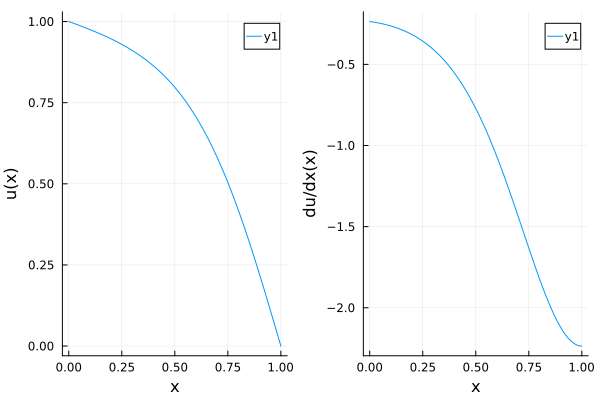

In [15]:
# plot u(x) and du/dx(x)
myv   = [u[1] for u in sol.u]
mydv  = [u[2] for u in sol.u]
rhog  = [u[3] for u in sol.u]
drhog = [u[4] for u in sol.u]
p1 = plot(sol.t, myv, xlabel="x", ylabel = "u(x)") 
p2 = plot(sol.t, mydv, xlabel="x", ylabel = "du/dx(x)") 
p3 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x)") 
p4 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x)") 
plot(p1,p2,p3,p4,layout=(2,2))

## Section 5.2: Conservation of mass - momentum 


<b>Problem to solve</b> Given $x \in \Omega = (0,1)$ and given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$ and pressure $p(x)$ (added stabilization terms in the conservation of mass)

$$
p''(x) = u'(x) \text{ (conservation of momentum)} 
$$

$$
u(x) \, u'(x) = 1/Re \, u''(x) + f(x) \text{ (conservation of momentum)}
$$

supplied with the following boundary conditions 


## Section 5.3: Conservation of mass - momentum - energy

1. add transport equation and source term (((de-)compression of gas) for the energy (enthalpy or temperature) to the previous model; 
1. add ideal gas law as equation of state; 

<b>Problem to solve</b> Given $x \in \Omega = (0,1)$ and given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$, pressure $p(x)$ and enthalpy (added stabilization terms in the conservation of mass)

# Section 6: One-Dimensional Model with More Realistic Flow Profile 

1D model for conservation of momentum and hydrogn gas transport

In [2]:
# set source function 
src(x) = 1-x  

# set right-hand side 
# u''(x) + u'(x) = f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    v = u[1]; dv = u[2]; rhog = u[3]; drhog = u[4]
    du[1] = dv 
    du[2] = v*dv + src(x)
    du[3] = drhog
    du[4] = v*drhog + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    vleft = 1; vright=0; rhogleft = 1; rhogright=0;
    residual[1] = u[1][1] - vleft 
    residual[2] = u[end][1] - vright
    residual[3] = u[1][3] - rhogleft 
    residual[4] = u[end][3] - rhogright
end

bc (generic function with 1 method)

In [3]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0., 0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


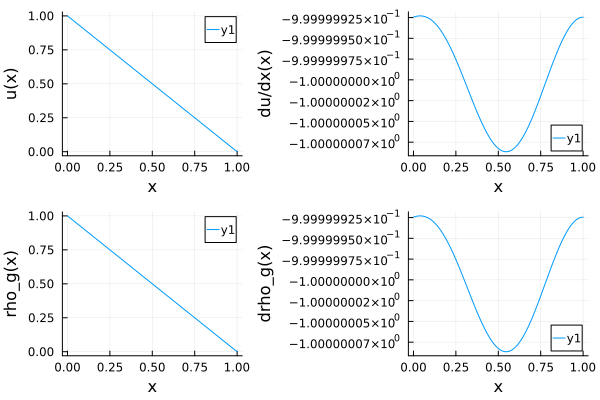

In [5]:
# plot u(x) and du/dx(x)
myv   = [u[1] for u in sol.u]
mydv  = [u[2] for u in sol.u]
rhog  = [u[3] for u in sol.u]
drhog = [u[4] for u in sol.u]
p1 = plot(sol.t, myv, xlabel="x", ylabel = "u(x)") 
p2 = plot(sol.t, mydv, xlabel="x", ylabel = "du/dx(x)") 
p3 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x)") 
p4 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x)") 
plot(p1,p2,p3,p4,layout=(2,2))

# Section 7: Geometry Modeling and Mesh Generation 


## Geometry Modeling 

Make sure to use Physical Groups to code boundary patches for inlet, outlet, wall and symmetry. 

Represent cylinder as wedge with periodic boundary conditions. 

## Mesh Generation 

## Writing Mesh to File 

# Section 8: Solid/Gas Density in 2D Cylindrical Reactor with Porous Material  


Extend previous analysis from 1D space (only $x$) to 2D space (both $x$ and $y$). Assume a predefined velocity fiedld for the gas phase velocity. Solve 2 coupled convection-diffusion-reaction equations for $\rho_s(x,y,t)$ and $\rho_g(x,y,t)$. 
1. Adapt [Ferrite Heat Equation Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/heat_equation/) (steady state) from from one field to be solved to two fields to be solved for;
1. Similarly, adapt [transient_heat_equation](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/transient_heat_equation/) from from one field to be solved to two fields to be solved for; 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

# Section 9: Laminar Iso-Thermal Porous Media Flow (Pressure/Velocity) in Reactor 



The goal of this section is to implement a laminar flow model for the gas phase in the reactor filled with porous material.

Adapt [Ferrite Porous Media Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/porous_media/) to cylindrical reactor geometry and flow conditions;    

<b>Assumptions</b>: 

<b>Problem Formulation</b>: PDE + boundary conditions for inlet (fix velocity), outlet (fix pressure), wall (no slip) and symmetry;  

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

# Section 10: Laminar Non-Iso-Thermal Porous Media Flow in Reactor


Add heat effects to the flow field.  

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

# Section 11: Hydrogen Ab/Desoprtion in Reactor 


Ad hydrogen absorption and desorption to the model. 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

# Section 12: Conclusions 

# References

[1] Dr. Lahaye's work : https://github.com/ziolai/finite_element_electrical_engineering/blob/main/project-based-assignment/metal-hydride-storage/notebooks/darzi-2016.ipynb

[2] A Comprehensive Literature Review on Hydrogen Tanks - Storage, Safety, and Structural Integrity : https://partage.bordeaux-inp.fr/service/home/~/?auth=co&loc=fr_FR&id=11220&part=2 

[3] Dr. Lahaye's work : 
https://github.com/ziolai/finite_element_electrical_engineering/tree/main/project-based-assignment/metal-hydride-storage/notebooks   